On perlmutter: use kernel pytorch-1.13.1

In [ ]:
!pip install nflows

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

import os
import torch


from numba import cuda 

from helpers.make_flow import *
from helpers.train_flow import *
from helpers.make_BC import *
from helpers.train_BC import *
from helpers.plotting import *

seed = 8

In [2]:
# computing
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = cuda.get_current_device()
device.reset()

# set the number of threads that pytorch will use
torch.set_num_threads(2)

# set gpu device
device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")
print( "Using device: " + str( device ), flush=True)

Using device: cuda


In [19]:
# Plotting params for later


scaled_bins = [np.linspace(-3.5, 3.5, 60) for i in range(9)]

kwargs_dict = {"SB":  {"density": True, 
                       "histtype": "step", 
                       "color":"blue",
                       "label": "SB"},
               
              "SR":  {"density": True, 
                       "histtype": "step", 
                       "color":"red",
                       "label": "SR"},
              "SB_samples":  {"density": True, 
                       "histtype": "stepfilled", 
                       "color":"blue",
                       "label": "SB samples",
                       "alpha": 0.4},
               
              "SR_samples":  {"density": True, 
                       "histtype": "stepfilled", 
                       "color":"red",
                       "label": "SR samples",
                       "alpha": 0.4}}


SB data has shape (2669, 9).
SR data has shape (559, 9).


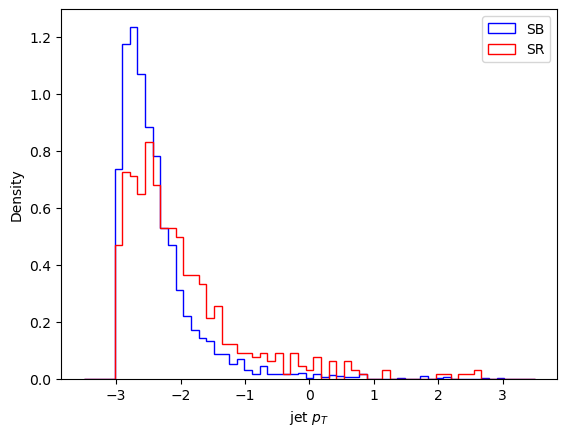

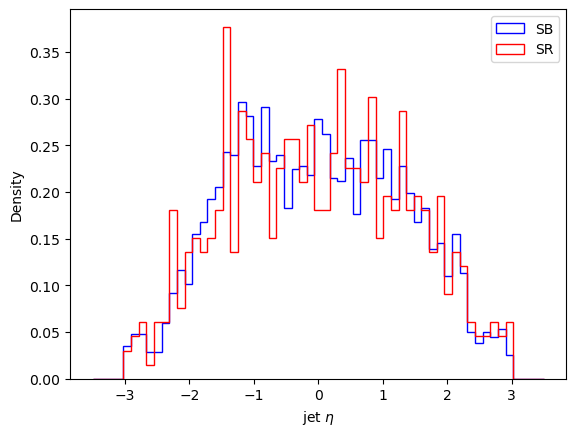

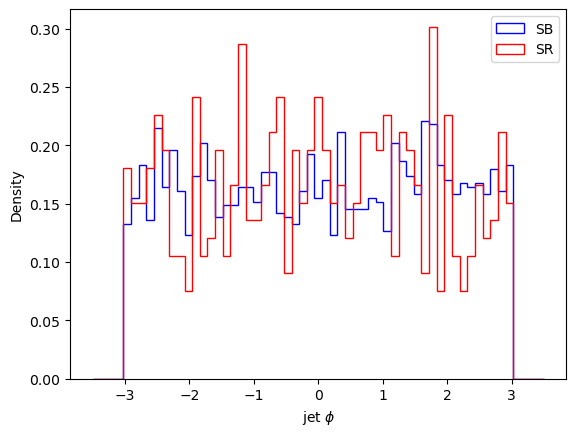

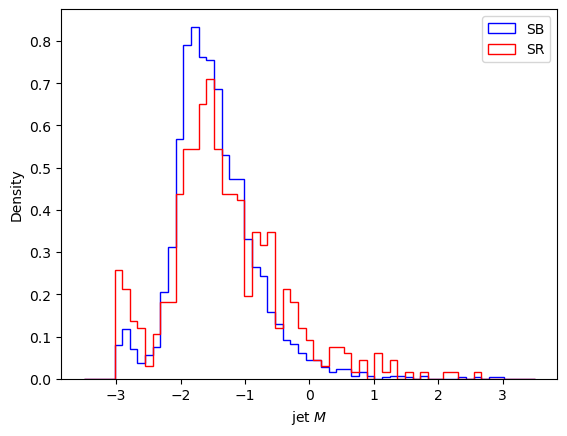

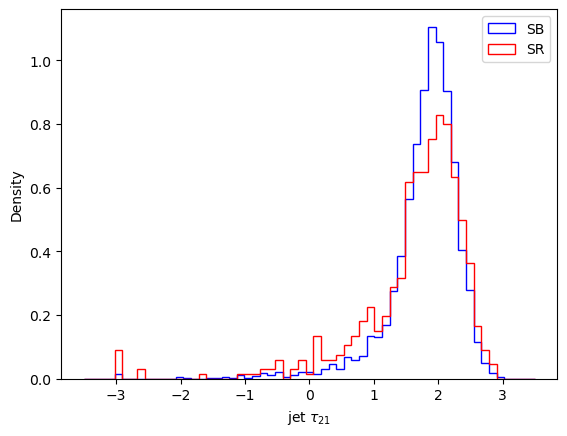

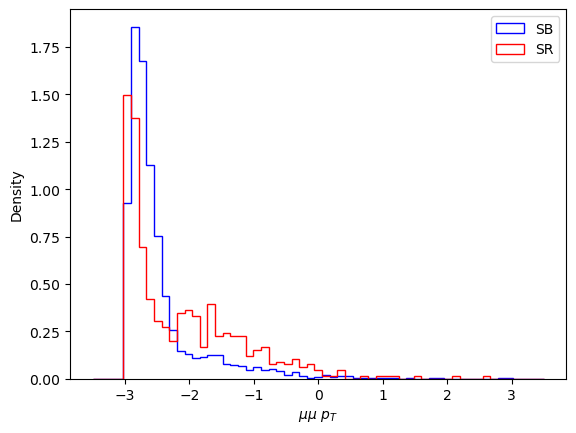

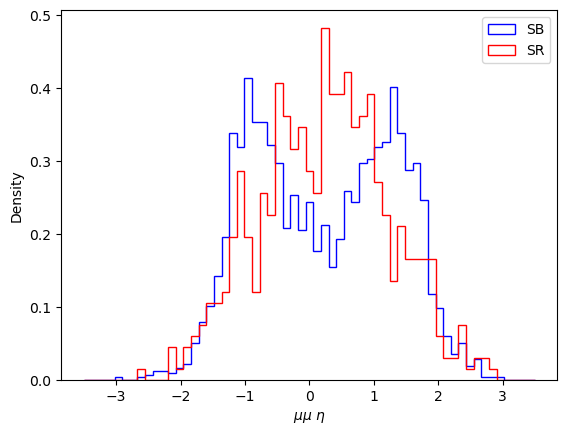

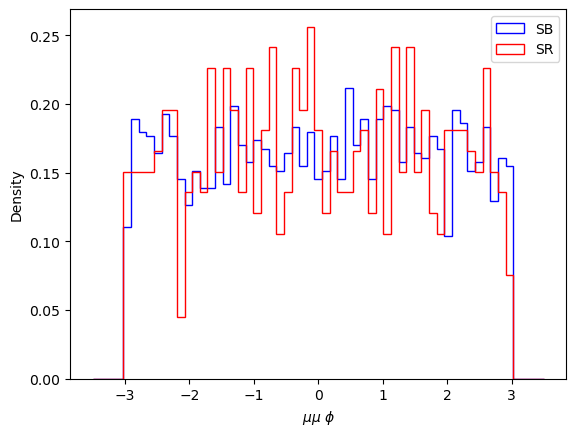

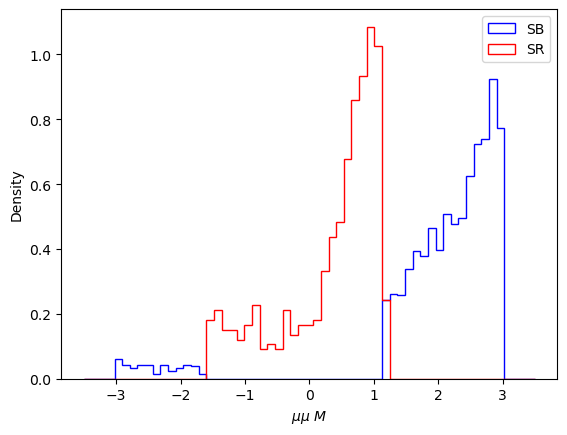

In [10]:
# load in the data

data_dict = {}

data_dict["SB"] = np.load(f"processed_data/od_SB_minmax.npy")
data_dict["SR"] = np.load(f"processed_data/od_SR_minmax.npy")

print("SB data has shape {length}.".format(length = data_dict["SB"].shape))
print("SR data has shape {length}.".format(length = data_dict["SR"].shape))

hist_all_features(["SB", "SR"], data_dict, kwargs_dict, scaled_bins)


In [11]:
# train val test split
from sklearn.model_selection import train_test_split

SB_data_train, SB_data_val = train_test_split(data_dict["SB"], test_size=0.2, random_state=42)

print(f"SB train data has shape {SB_data_train.shape}.")
print(f"SB val data has shape {SB_data_val.shape}.")

num_features = 8

SB train data has shape (2135, 9).
SB val data has shape (534, 9).


## Flow creation and training

In [12]:
# Create the flow

# This will be the upper subdirectory in saved_models/

num_layers = 2
num_hidden_features = 128
num_blocks = 8
flow_training_id = f"Masked_PRQ_AR_{num_layers}layers_{num_blocks}hidden_{num_blocks}blocks_{seed}seed"

flow_training_dir = os.path.join("models", f"{flow_training_id}/")
os.makedirs(flow_training_dir, exist_ok=True)

hyperparameters_dict = {"n_epochs":50,
                          "batch_size": 128,
                          "lr": 0.0005,
                          "weight_decay": 0.0001}


test_flow = make_masked_AR_flow(num_features, num_layers, num_hidden_features, num_blocks)


In [13]:

epochs, losses, losses_val, best_epoch = train_flow(test_flow, hyperparameters_dict, device, SB_data_train, SB_data_val, flow_training_dir, seed = seed)


Training flow for 50 epochs ...



 56%|█████▌    | 28/50 [00:30<00:23,  1.08s/it]

Done training!


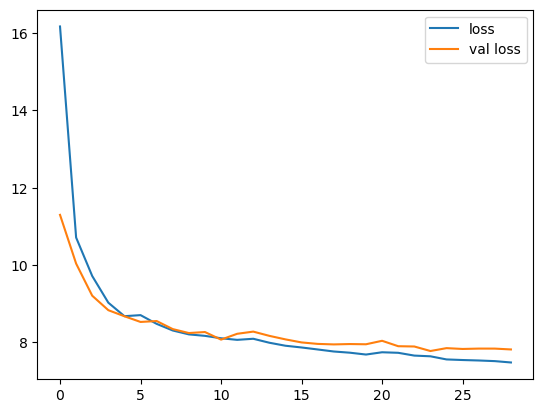

23


In [14]:
plt.figure()
plt.plot(epochs, losses, label = "loss")
plt.plot(epochs, losses_val, label = "val loss")
plt.legend()
plt.show()

print(best_epoch)

In [20]:
# sample from the flow

   
# Load in model
config_string = "epochs{0}_lr{1}_wd{2}_bs{3}".format(hyperparameters_dict["n_epochs"], hyperparameters_dict["lr"], hyperparameters_dict["weight_decay"], hyperparameters_dict["batch_size"])
checkpoint_path = os.path.join(flow_training_dir, f"{config_string}")
    

def sample_from_flow(flow_path, device, context):
    
    print(f"Loading in the best flow model model ...")
    flow_best = torch.load(f"{flow_path}_best_model.pt")
    flow_best.to(device)


    # freeze the trained model
    for param in flow_best.parameters():
        param.requires_grad = False
    flow_best.eval()

    context_masses = torch.tensor(context.reshape(-1,1)).float().to(device)
    SB_samples = flow_best.sample(1, context=context_masses).detach().cpu().numpy()
    SB_samples = SB_samples.reshape(SB_samples.shape[0], 8)

    SB_samples = np.hstack((SB_samples, np.reshape(context, (-1, 1))))
    
    return SB_samples


data_dict["SB_samples"] = sample_from_flow(checkpoint_path, device, data_dict["SB"][:,-1])
print(data_dict["SB_samples"].shape)

data_dict["SR_samples"] = sample_from_flow(checkpoint_path, device, data_dict["SR"][:,-1])
print(data_dict["SR_samples"].shape)

Loading in the best flow model model ...
(2669, 9)
Loading in the best flow model model ...
(559, 9)


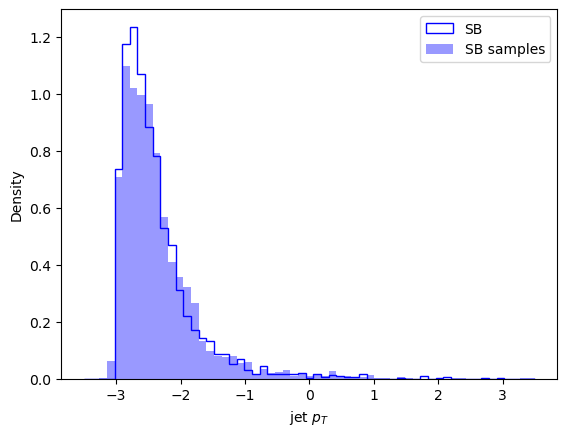

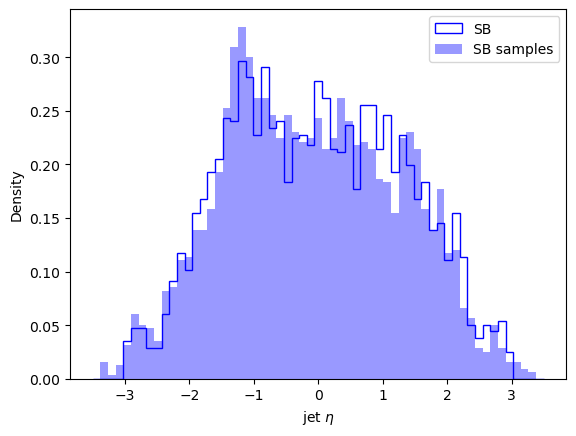

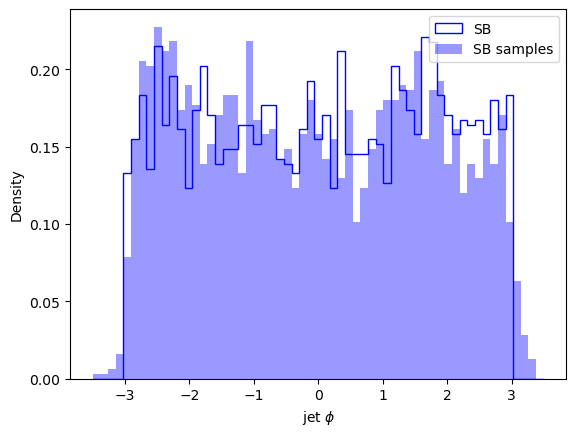

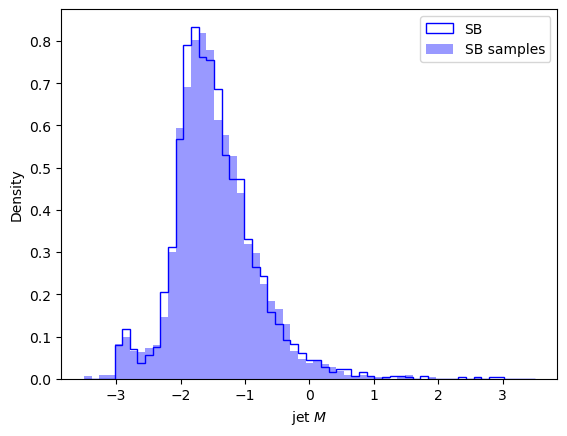

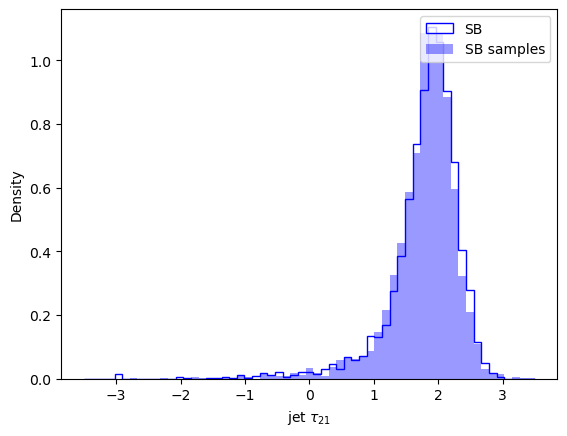

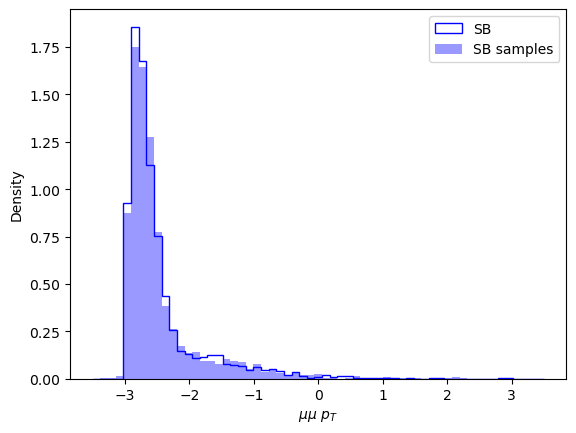

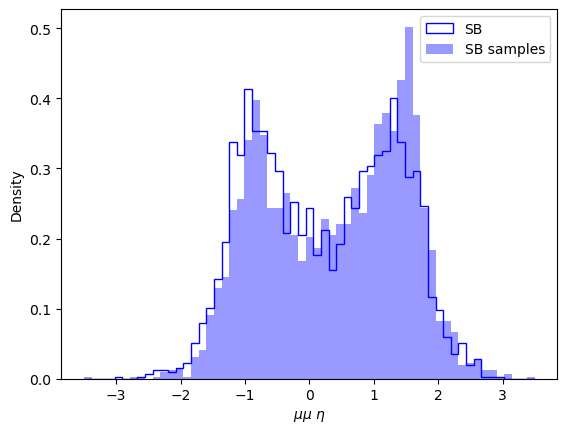

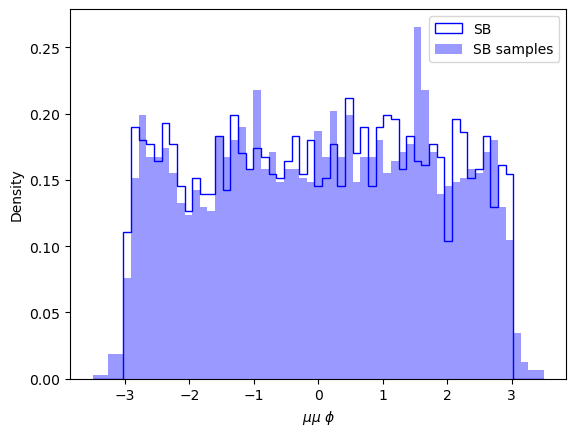

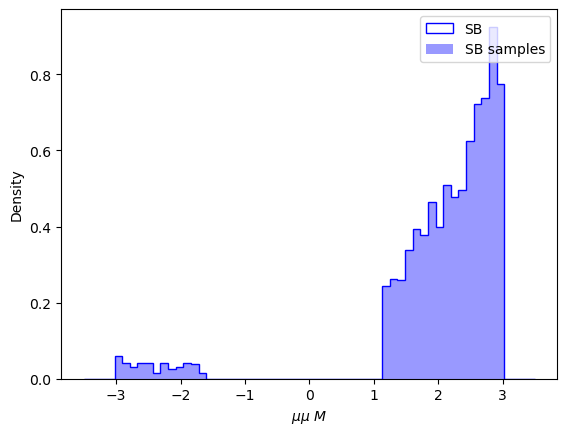

In [21]:


hist_all_features(["SB", "SB_samples"], data_dict, kwargs_dict, scaled_bins)


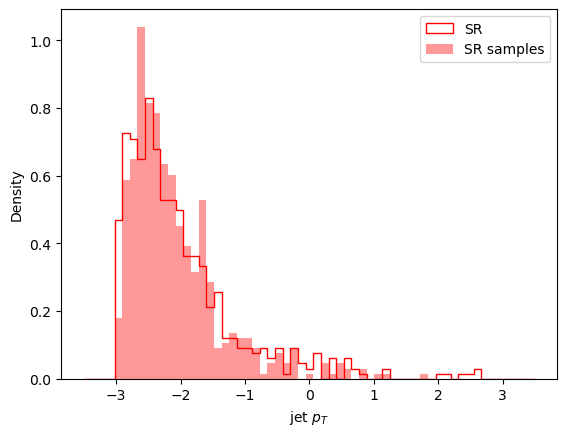

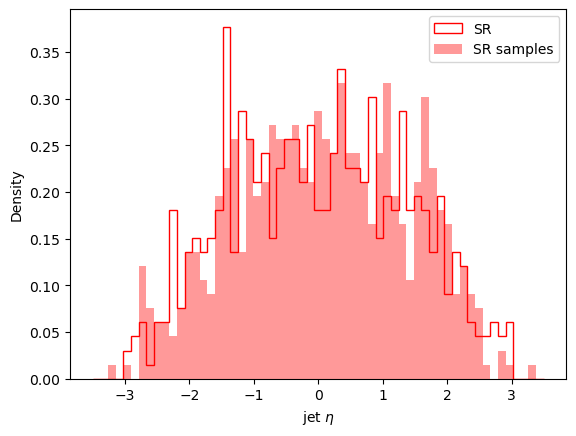

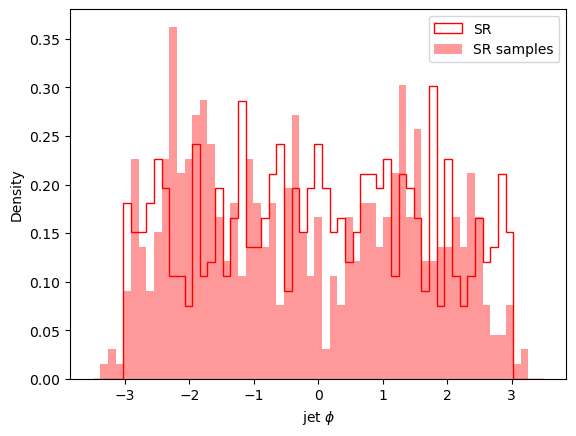

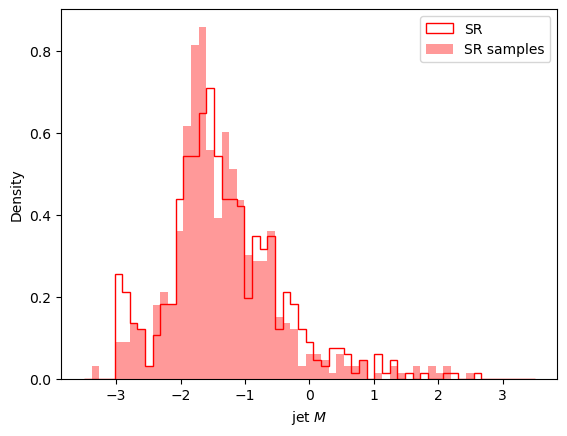

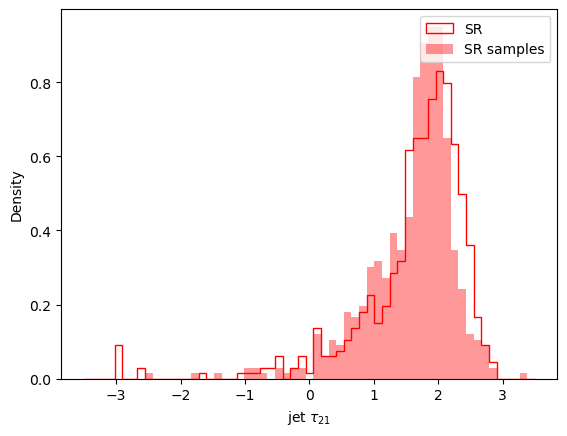

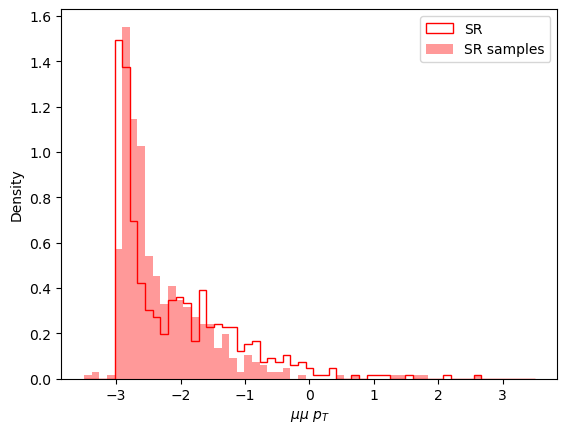

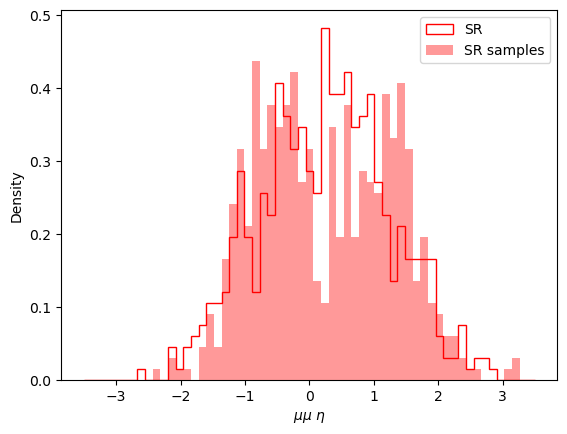

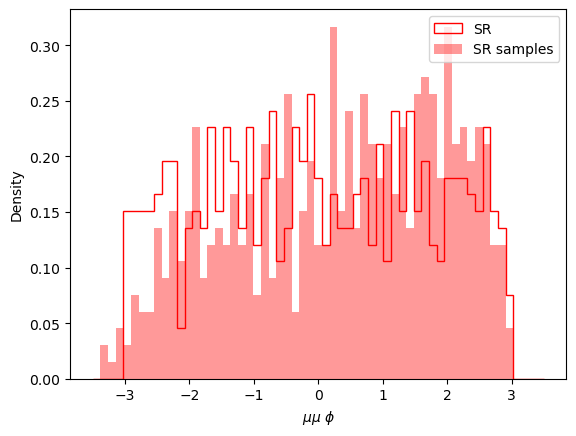

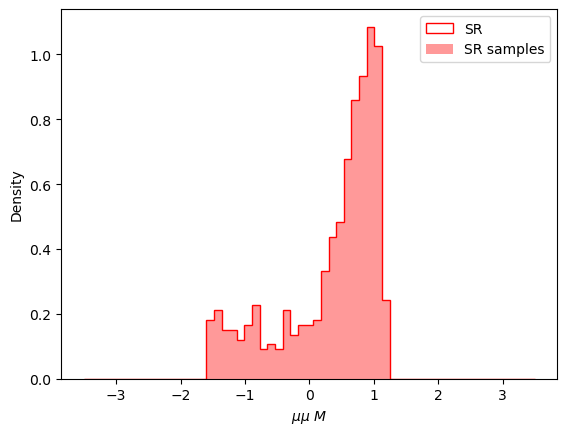

In [22]:
hist_all_features(["SR", "SR_samples"], data_dict, kwargs_dict, scaled_bins)


## BC training

Using seed 8...
Train data, labels shape: (1118, 8) (1118, 1)
Test data, labels  shape: (1118, 8) (1118, 1)
FOLD 0
--------------------------------


 34%|███▍      | 34/100 [00:00<00:01, 45.31it/s]


Done training fold 0. Best val loss 0.6895291209220886 at epoch 29
FOLD 1
--------------------------------


 25%|██▌       | 25/100 [00:00<00:01, 46.22it/s]


Done training fold 1. Best val loss 0.6783502101898193 at epoch 20
FOLD 2
--------------------------------


 40%|████      | 40/100 [00:00<00:01, 44.24it/s]


Done training fold 2. Best val loss 0.6889626979827881 at epoch 35
FOLD 3
--------------------------------


 46%|████▌     | 46/100 [00:00<00:01, 46.40it/s]


Done training fold 3. Best val loss 0.6822475790977478 at epoch 41
FOLD 4
--------------------------------


  7%|▋         | 7/100 [00:00<00:02, 42.77it/s]


Done training fold 4. Best val loss 0.6901516318321228 at epoch 2
Loading in best model for models/Masked_PRQ_AR_2layers_8hidden_8blocks_8seed//.bc_fold1.pt, val loss 0.6783502101898193 from fold 1


(0.5962650529152171,
 array([[0.4242462 ],
        [0.5547591 ],
        [0.44452772],
        ...,
        [0.42203945],
        [0.56191206],
        [0.54219556]], dtype=float32))

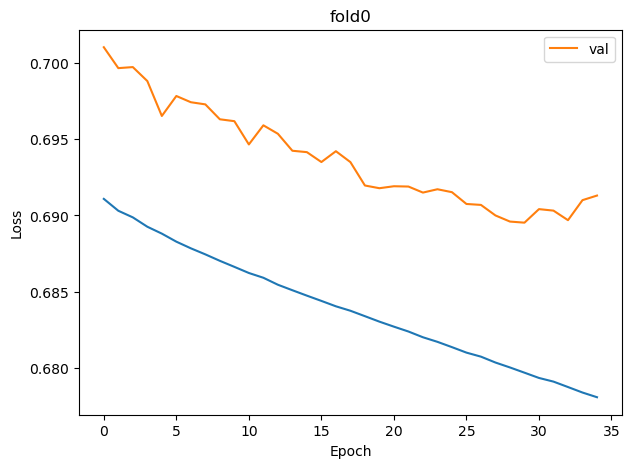

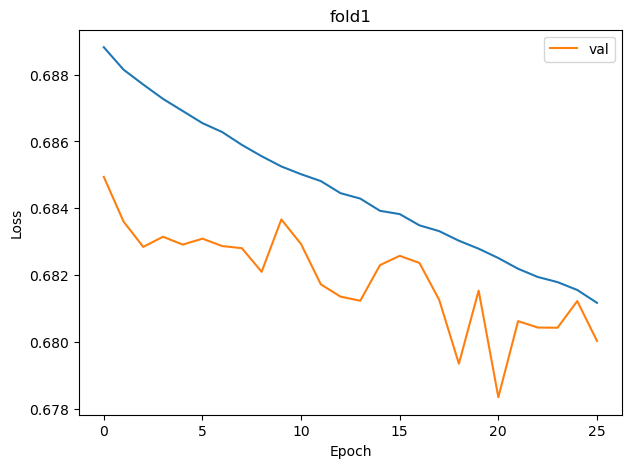

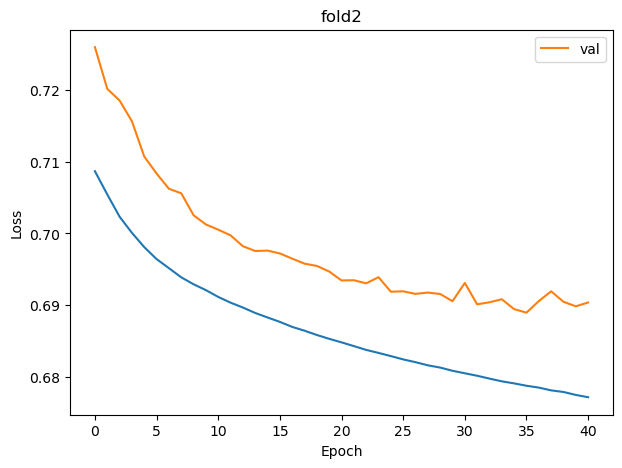

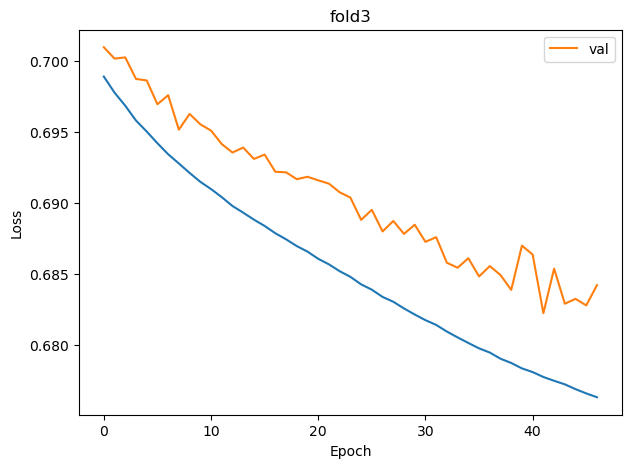

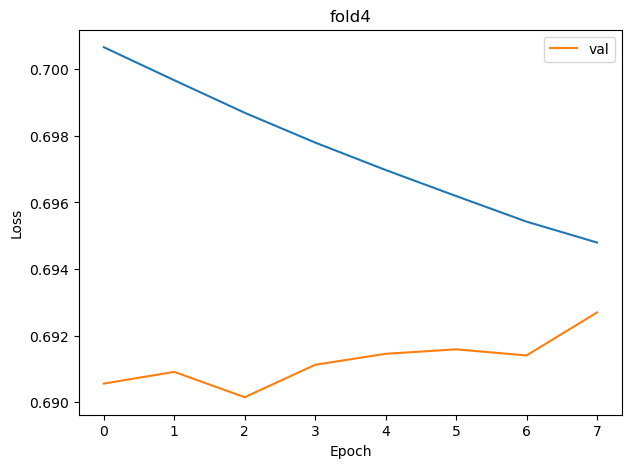

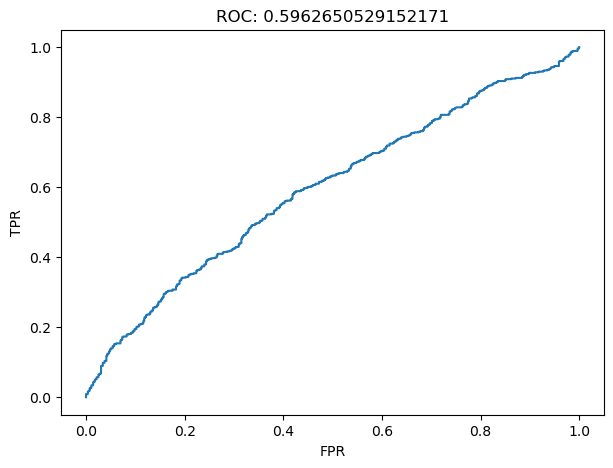

In [23]:
hyperparameters_dict_BC = {"n_epochs":100,
                          "batch_size": 128,
                          "lr": 0.0001,
                         }


discriminate_datasets_kfold(flow_training_dir, data_dict["SR_samples"][:,:-1],  data_dict["SR"][:,:-1], 
                            np.ones((data_dict["SR_samples"].shape[0],1)), np.ones((data_dict["SR"].shape[0],1)), 
                               data_dict["SR_samples"][:,:-1], data_dict["SR"][:,:-1], 
                            num_features, hyperparameters_dict_BC, device, seed = seed)



